In [ ]:
# 1) try rf model on all england data just like NN
# 2) If no good try it on the top 3 cities together 
# 3) then try it on each city separately
# 4) try xgboost
# 5) try mixture model

In [2]:
import os 
import time
import re
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

import optuna
from optuna.samplers import TPESampler
from optuna.trial import TrialState

# RF with all England MSOAs


### Loading and processing data

In [3]:
# load in the data as df
pwd = os.getcwd()
#print(pwd)

data = pd.read_csv(pwd+'/data/normalized_percents.csv')

# change all column names to lowercase
data.columns = data.columns.str.lower()

# drop 2001 since income 0 and also drop rows where income is 0
data = data[data['year'] != 2001]
data = data[data['total annual income (£)'] != 0]

#zero = set(data[data['year'] == 2001]['msoa code'].tolist())
one = set(data[data['year'] == 2011]['msoa code'].tolist())
two = set(data[data['year'] == 2021]['msoa code'].tolist())

common_index = one.intersection(two)
mask = data['msoa code'].isin(common_index)
data = data[mask]

# creating summed column of higher occupation for pca score later
occ_pat = '(^occupation:\smanager.*)|(^occupation.*professional.*)'
    
occ_match = re.compile(occ_pat)
co = [c for c in data.columns.tolist() if occ_match.match(c)]

data['higher_occupation'] = data[co].sum(axis=1)

#print(len(data))

# check the column names 
#cols = data.columns.tolist()
#cols # doesn't look like SES score is there
#print(len(data)) 9779 rows in original data

# load the ses scores
#ses_data = pd.read_csv(pwd+'/data/scores.csv')

In [4]:
# scaling - log transform on income and then scaling introduces 82 rows == 0

# set pincode to index
exp1_data = data.set_index('msoa code')
#print(exp1_data.year)

# get log of income and house price
exp1_data['median house price'] = np.log(exp1_data['median house price'])
exp1_data['total annual income (£)'] = np.log(exp1_data['total annual income (£)'])



### Scaling data

In [5]:
# turn the year column into a string
exp1_data['year'] = exp1_data['year'].astype(str)

# get the non-numeric cols
exp1_nonnumeric = exp1_data.select_dtypes(include='object') # has 9779 rows

# get numeric columns only NEED TO EXCLUDE YEAR
exp1_numeric = exp1_data.select_dtypes(include='number')
#print(len(exp1_numeric.columns))
scaler = preprocessing.RobustScaler().fit(exp1_numeric)
exp1_scaled = scaler.transform(exp1_numeric) # still maintains 9779 rows

exp1_numeric = pd.DataFrame(exp1_scaled, index=exp1_numeric.index, columns=exp1_numeric.columns) # 9779 rows
exp1_numeric['year'] = exp1_nonnumeric['year']
#print(exp1_numeric['year'].head())

# merge back into single df
exp1_processed = exp1_nonnumeric.merge(exp1_numeric, how='inner', on=['msoa code', 'year'])

#print(len(exp1_processed))

### Creating SES variable

In [6]:
# creating the df of variables to create ses score

pattern = '(year)|(.*level 4.*)|(.*price.*)|(.*income.*)|(higher_occupation)'
    
m = re.compile(pattern)
cols = [c for c in data.columns.tolist() if m.match(c)]
#print(cols)

ses_vars = exp1_processed[cols]

ses_vars.sort_values(by=['year','msoa code'], ascending=True, inplace=True)
#print(ses_vars.head())


print(ses_vars.head())

           year  \
msoa code         
E02000001  2011   
E02000002  2011   
E02000003  2011   
E02000004  2011   
E02000005  2011   

           highest level of qualification: level 4 qualifications or above  \
msoa code                                                                    
E02000001                                           2.079763                 
E02000002                                          -0.578862                 
E02000003                                          -0.300022                 
E02000004                                          -0.595959                 
E02000005                                          -0.610861                 

           median house price  total annual income (£)  higher_occupation  
msoa code                                                                  
E02000001            1.047336                 1.408548           1.843460  
E02000002           -0.047193                -0.340952          -0.495484  
E02000003      

/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/3307025896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ses_vars.sort_values(by=['year','msoa code'], ascending=True, inplace=True)


In [7]:
# pca for ses score
ses_np_scaled = ses_vars.drop('year', axis=1).to_numpy()

pca = decomposition.PCA(n_components=1, random_state=16)
pca.fit(ses_np_scaled)

first_comp = pca.transform(ses_np_scaled)

num_msoa_year = len(ses_vars) // 2
#print(type(num_msoa_year))

scores11 = first_comp[ :num_msoa_year]
scores21 = first_comp[num_msoa_year: ]
#scores21 = first_comp[2*num_msoa_year: ]

assert len(scores11) + len(scores21) == len(ses_vars), 'scores and ses_vars differ in num rows'

# change from np arrays to df and add the index
#ses_vars01 = ses_vars[ses_vars['year'] == 2001]
ses_vars11 = ses_vars[ses_vars['year'] == '2011']
ses_vars21 = ses_vars[ses_vars['year'] == '2021']

#scores01 = pd.DataFrame(scores01, index=ses_vars01.index)
#scores01 = scores01.rename(columns={0: 'ses_score'})
scores11 = pd.DataFrame(scores11, index=ses_vars11.index)
scores11 = scores11.rename(columns={0: 'ses_score'})
scores21 = pd.DataFrame(scores21, index=ses_vars21.index)
scores21 = scores21.rename(columns={0: 'ses_score'})

scores_combined = scores11.merge(scores21, how='inner',on='msoa code',suffixes=['_11', '_21'])
#scores_combined = scores_combined.rename(columns={'ses_score':'ses_score_21'})
print(scores_combined.head())

           ses_score_11  ses_score_21
msoa code                            
E02000001      3.060824      3.849733
E02000002     -0.892658     -0.029974
E02000003     -0.298174      0.389150
E02000004     -0.590434      0.403378
E02000005     -0.878350      0.196340


In [9]:
pca.components_

array([[0.53179603, 0.48547477, 0.48680423, 0.4944986 ]])

### Checking the density of SES var

/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1643501140.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores_combined['ses_score_11'], shade=True, ax=axes[0])
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1643501140.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores_combined['ses_score_21'], shade=True, ax=axes[1])


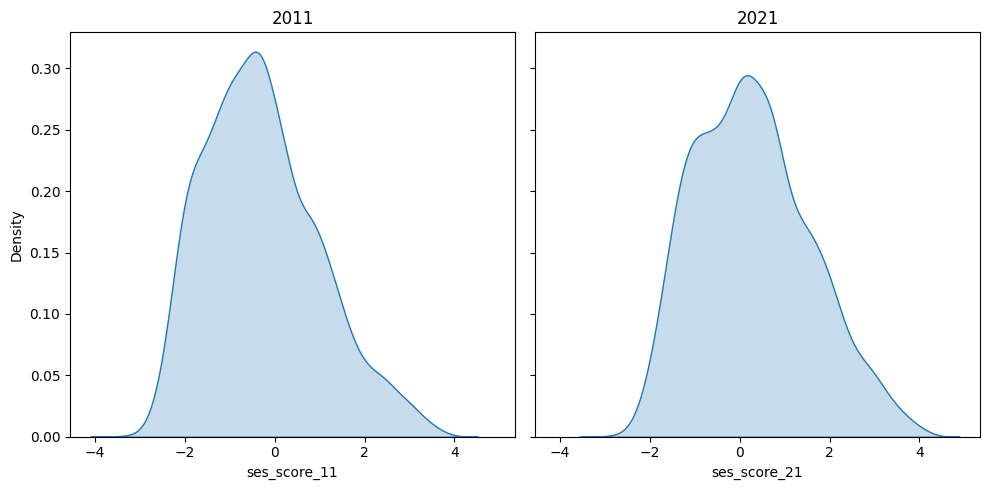

In [8]:
# look at the density of scores each year
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
#sns.kdeplot(scores_combined['ses_score_01'], shade=True, ax=axes[0])
#axes[0].set_title("2001")

sns.kdeplot(scores_combined['ses_score_11'], shade=True, ax=axes[0])
axes[0].set_title("2011")

sns.kdeplot(scores_combined['ses_score_21'], shade=True, ax=axes[1])
axes[1].set_title("2021")

plt.tight_layout()
plt.show()

### Final processing for data splitting and modeling

In [10]:
# takes into account negatives and gives correct change
#scores_combined['ses_diff_01_11'] = scores_combined['ses_score_11'] - scores_combined['ses_score_01']
scores_combined['ses_diff_11_21'] = scores_combined['ses_score_21'] - scores_combined['ses_score_11']

In [11]:
# combine processed data and score 

dep_11_21 = pd.DataFrame(scores_combined['ses_diff_11_21'])
year = pd.DataFrame(['2011']*len(dep_11_21), index=dep_11_21.index)
dep_11_21 = dep_11_21.merge(year, how='inner', on='msoa code')
dep_11_21.rename(columns={'ses_diff_11_21': 'y_var', 0: 'year'}, inplace=True)

# drop 2021 rows in exp1
data_processed = exp1_processed[exp1_processed['year'] != '2021']
#print(len(data_processed.columns))

# drop higher_occupation column from data_processed
data_processed.drop('higher_occupation', axis=1, inplace=True)
#print(len(data_processed.columns))

# combine dependent and ind vars
data_processed = data_processed.merge(dep_11_21, how='inner', on=['msoa code', 'year'])


/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/2095139946.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed.drop('higher_occupation', axis=1, inplace=True)


In [12]:
# get 2011 data and do train test split
#data_proc_2001 = data_processed[data_processed['year'] == '2001']

# get the data ready for modeling

# drop the year column
data_processed = data_processed.drop(['year', 'msoa name', 'city code', 'city name'], axis=1)
X = data_processed.loc[:, data_processed.columns != 'y_var'].to_numpy()
y = data_processed['y_var'].to_numpy()

# split data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=386)


### Baseline SKLearn RF model

In [ ]:
# train baseline random forest and get the metrics
untuned_rf = RandomForestRegressor(random_state=89)

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=75)

mse_untuned_rf_cv = cross_val_score(untuned_rf, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
mae_untuned_rf_cv = cross_val_score(untuned_rf, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

mse_untuned_rf = np.mean(np.abs(mse_untuned_rf_cv))
mae_untuned_rf = np.mean(np.abs(mae_untuned_rf_cv))

untuned_rf.fit(X_train, y_train)
y_pred = untuned_rf.predict(X_test)

print(f'Untuned RF 5-fold CV MSE: {mse_untuned_rf}\nUntuned RF 5-fold CV MAE: {mae_untuned_rf}\n')

print(f'Test MSE using untuned RF:{mean_squared_error(y_test, y_pred)}')
print(f'Test MAE using untuned RF:{mean_absolute_error(y_test, y_pred)}')

In [25]:
X_train.shape

(2230, 211)

### RF hyperparameter tuning

In [32]:
# setting up the objective function of hyperopt

def objective(trial):
    
    rf_params = {
    'criterion': trial.suggest_categorical('criterion', ['absolute_error', 'squared_error']),
    'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
    'max_depth': trial.suggest_int('max_depth', 10, 60, 5),
    'max_features': trial.suggest_categorical('max_features', ['sqrt']),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 8, 2)
}
    
    # init model
    rf = RandomForestRegressor(**rf_params, n_jobs=-1)
    
    #rf.fit(X_train, y_train)
    
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=75)
    mse = cross_val_score(rf, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    
    return -mse.mean()

In [33]:

sampler = TPESampler(seed=440)
rf_study = optuna.create_study(direction='minimize', sampler=sampler)
rf_study.optimize(objective, n_trials=150, timeout=600)

print("Best Trial:")
rf_trial = rf_study.best_trial

print("  Params: ")
for key, value in rf_study.best_trial.params.items():
    print("    {}: {}".format(key, value))


[I 2024-04-16 10:35:34,385] A new study created in memory with name: no-name-aeb2d918-0580-4e80-96ce-c74b1fd5ebc6
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4187629524.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4187629524.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 10, 60, 5),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4187629524.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 8, 2)
[I 2024-04-16 10:35:47,469] Trial 0 finished with value: 0.03367294227242788 

[I 2024-04-16 10:42:41,370] Trial 7 finished with value: 0.03427639391186686 and parameters: {'criterion': 'absolute_error', 'n_estimators': 1900, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 2}. Best is trial 5 with value: 0.03294354378325652.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4187629524.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4187629524.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 10, 60, 5),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4187629524.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-04-16 10:44:34,372] Trial 15 finished with value: 0.033257134902581684 and parameters: {'criterion': 'squared_error', 'n_estimators': 400, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 4}. Best is trial 5 with value: 0.03294354378325652.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4187629524.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4187629524.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 10, 60, 5),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4187629524.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-04-16 10:45:18,280] Trial 23 finished with value: 0.03291385619225684 and parameters: {'criterion': 'squared_error', 'n_estimators': 800, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2}. Best is trial 23 with value: 0.03291385619225684.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4187629524.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4187629524.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 10, 60, 5),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4187629524.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

Best Trial:
  Params: 
    criterion: squared_error
    n_estimators: 800
    max_depth: 20
    max_features: sqrt
    min_samples_leaf: 2


### Optimal RF model performance

In [37]:
def change_metrics(y_true, y_pred, dataset='Valid'):
    
    # should only pass in numpy arrays
    
    # calculate how many sd away each is for true
    true_mean, true_sd = np.mean(y_true), np.std(y_true)
    true_sd_change = (y_true - true_mean) / true_sd
    
    # for pred calculate how much change
    pred_mean, pred_sd = np.mean(y_pred), np.std(y_pred)
    pred_sd_change = (y_pred - pred_mean) / pred_sd
    
    true_sd_change_cls = true_sd_change >= 1.0
    true_sd_change_cls = true_sd_change_cls.astype(int)
    
    pred_sd_change_cls = pred_sd_change >= 1.0
    pred_sd_change_cls = pred_sd_change_cls.astype(int)
    
    y_acc = accuracy_score(true_sd_change_cls, pred_sd_change_cls)
    y_bacc = balanced_accuracy_score(true_sd_change_cls, pred_sd_change_cls)
    y_f1 = f1_score(true_sd_change_cls, pred_sd_change_cls)

    print(f'{dataset} Accuracy: {y_acc}')
    print(f'{dataset} Balanced Accuracy: {y_bacc}')
    print(f'{dataset} F1: {y_f1}')

In [34]:
rf_best_trial = rf_study.best_trial.params
rf_best_trial

{'criterion': 'squared_error',
 'n_estimators': 800,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2}

In [36]:
# training and testing prediction

opt_rf = RandomForestRegressor(**rf_best_trial).fit(X_train, y_train)

rf_train_preds = opt_rf.predict(X_train)

rf_test_preds = opt_rf.predict(X_test)

In [38]:
# train performance

change_metrics(y_train, rf_train_preds, dataset='Train')

Train Accuracy: 0.9556053811659193
Train Balanced Accuracy: 0.9267513822905209
Train F1: 0.8502269288956127


In [39]:
# test performance

change_metrics(y_test, rf_test_preds)

Valid Accuracy: 0.8861024033437827
Valid Balanced Accuracy: 0.7810944398515417
Valid F1: 0.6175438596491228


In [57]:
def rf_obj2(trial):
    
    rf_params = {
    'criterion': trial.suggest_categorical('criterion', ['absolute_error', 'squared_error']),
    'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
    'max_depth': trial.suggest_int('max_depth', 2, 60, 1),
    'max_features': trial.suggest_categorical('max_features', ['sqrt']),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 12, 2)
}
    
    # init model
    rf = RandomForestRegressor(**rf_params, n_jobs=-1)
    
    #rf.fit(X_train, y_train)
    
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=75)
    mse = cross_val_score(rf, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    
    return -mse.mean()

In [58]:
rf2_study = optuna.create_study(direction='minimize', sampler=sampler)
rf2_study.optimize(rf_obj2, n_trials=150, timeout=600)

print("Best Trial:")
rf2_trial = rf2_study.best_trial

rf2_best_trial = rf2_study.best_trial.params
rf2_best_trial

[I 2024-04-16 12:15:13,141] A new study created in memory with name: no-name-17c2c04c-d8d9-4f20-bfed-a194daa6887b
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4226797721.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4226797721.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 2, 60, 1),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4226797721.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 12, 2)
[I 2024-04-16 12:15:19,462] Trial 0 finished with value: 0.03483324174258416 a

[I 2024-04-16 12:17:45,418] Trial 7 finished with value: 0.03546142741357914 and parameters: {'criterion': 'absolute_error', 'n_estimators': 600, 'max_depth': 22, 'max_features': 'sqrt', 'min_samples_leaf': 6}. Best is trial 2 with value: 0.03330483513834623.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4226797721.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4226797721.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 2, 60, 1),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4226797721.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  

[I 2024-04-16 12:20:14,212] Trial 15 finished with value: 0.03328634330982454 and parameters: {'criterion': 'squared_error', 'n_estimators': 1600, 'max_depth': 26, 'max_features': 'sqrt', 'min_samples_leaf': 4}. Best is trial 11 with value: 0.032928855948320776.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4226797721.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4226797721.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 2, 60, 1),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4226797721.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-04-16 12:23:57,632] Trial 23 finished with value: 0.032995017093677734 and parameters: {'criterion': 'squared_error', 'n_estimators': 800, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 2}. Best is trial 20 with value: 0.0329167313476224.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4226797721.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4226797721.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 2, 60, 1),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/4226797721.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
 

Best Trial:


{'criterion': 'squared_error',
 'n_estimators': 1300,
 'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 2}

In [60]:
# training and testing prediction

opt_rf2 = RandomForestRegressor(**rf2_best_trial).fit(X_train, y_train)

rf2_train_preds = opt_rf2.predict(X_train)

rf2_test_preds = opt_rf2.predict(X_test)

In [63]:
# train performance

change_metrics(y_train, rf2_train_preds, dataset='Train')

Train Accuracy: 0.9547085201793722
Train Balanced Accuracy: 0.9249127256476936
Train F1: 0.8472012102874432


In [64]:
# test performance

change_metrics(y_test, rf2_test_preds)

Valid Accuracy: 0.8913270637408568
Valid Balanced Accuracy: 0.7931083006455472
Valid F1: 0.6363636363636364


# XGBoost 
Including all MSOAS

In [40]:
import xgboost as xgb

In [71]:
# setting up the objective function of hyperopt

def xg_obj(trial):
    
    xg_params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 50),
    'max_depth': trial.suggest_int('max_depth', 2, 60, 1),
    'min_child_weight': trial.suggest_int('min_child_weight', 2, 20, 2),
    'gamma': trial.suggest_int('gamma', 0, 50, 2),
    'eta': trial.suggest_float('eta', low=0.0, high=1.0, step=0.2),
    'alpha': trial.suggest_categorical('alpha', [x for x in np.linspace(0, 100, 20)]),
    'lambda': trial.suggest_categorical('lambda', [x for x in np.linspace(1, 20, 10)]),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 8, 2),
    'subsample': trial.suggest_float('subsample', low=0.5, high=1.0, step=0.1)
}
    
    # init model
    xg = xgb.XGBRegressor(**xg_params, n_jobs=-1)
    
    #rf.fit(X_train, y_train)
    
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=75)
    mse = cross_val_score(xg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    
    return -mse.mean()

In [72]:
xg_study = optuna.create_study(direction='minimize', sampler=sampler)
xg_study.optimize(xg_obj, n_trials=150, timeout=600)

print("Best Trial:")
xg_trial = xg_study.best_trial

print("  Params: ")
for key, value in xg_study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-16 12:51:06,804] A new study created in memory with name: no-name-76c0a245-5ccd-407c-a258-39d6416b7ec4
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1747373268.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 50),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1747373268.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 2, 60, 1),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1747373268.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'min_child_weight': trial.suggest_int('min_child_weight', 2, 20, 2),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1747373268.py:

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-04-16 12:51:15,687] Trial 2 finished with value: 0.06473789783258181 and parameters: {'n_estimators': 1400, 'max_depth': 52, 'min_child_weight': 16, 'gamma': 50, 'eta': 0.6000000000000001, 'alpha': 15.789473684210527, 'lambda': 17.88888888888889, 'min_samples_leaf': 8, 'subsample': 0.7}. Best is trial 1 with value: 0.05438733147349044.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1747373268.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 50),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1747373268.py:7: FutureWarning: suggest_int() got {'step'} as posit

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-04-16 12:51:25,937] Trial 5 finished with value: 0.0647443499720263 and parameters: {'n_estimators': 250, 'max_depth': 27, 'min_child_weight': 8, 'gamma': 36, 'eta': 0.2, 'alpha': 31.578947368421055, 'lambda': 9.444444444444445, 'min_sampl

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-04-16 12:51:54,715] Trial 17 finished with value: 0.0647443499720263 and parameters: {'n_estimators': 100, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 24, 'eta': 0.4, 'alpha': 0.0, 'lambda': 11.555555555555555, 'min_samples_leaf': 6, 'subsample': 1.0}. Best is trial 11 with value: 0.0410450384497571.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1747373268.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-04-16 12:52:05,161] Trial 23 finished with value: 0.05663495869733377 and parameters: {'n_estimators': 100, 'max_depth': 2, 'min_child_weight': 6, 'gamma': 10, 'eta': 0.6000000000000001, 'alpha': 5.2631578947368425, 'lambda': 15.777777777777779, 'min_samples_leaf': 8, 'subsample': 0.9}. Best is trial 22 with value: 0.03307226996440345.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1747373268.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but t

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-04-16 12:52:08,268] Trial 26 finished with value: 0.0647443499720263 and parameters: {'n_estimators': 250, 'max_depth': 22, 'min_child_weight': 6, 'gamma': 12, 'eta': 0.4, 'alpha': 57.89473684210527, 'lambda': 5.222222222222222, 'min_sampl

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-04-16 12:52:45,625] Trial 44 finished with value: 0.051418578385530635 and parameters: {'n_estimators': 200, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 2, 'eta': 0.6000000000000001, 'alpha': 21.05263157894737, 'lambda': 17.88888888888

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-04-16 12:52:52,691] Trial 50 finished with value: 0.056437779872641536 and parameters: {'n_estimators': 150, 'max_depth': 12, 'min_child_weight': 2, 'gamma': 12, 'eta': 0.8, 'alpha': 10.526315789473685, 'lambda': 11.555555555555555, 'min_s

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-04-16 12:53:10,885] Trial 65 finished with value: 0.0647443499720263 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_child_weight': 2, 'gamma': 6, 'eta': 0.8, 'alpha': 52.631578947368425, 'lambda': 15.777777777777779, 'min_samples_leaf': 8, 'subsample': 1.0}. Best is trial 22 with value: 0.03307226996440345.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1747373268.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 50),
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1747373268.py:7: FutureWarning: suggest_int() got {'step'} as positional arguments 

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-04-16 12:53:13,718] Trial 68 finished with value: 0.045951549034218456 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 2, 'eta': 1.0, 'alpha': 5.2631578947368425, 'lambda': 7.333333333333334, 'min_samples_leaf': 6, 'subsample': 0.9}. Best is trial 22 with value: 0.03307226996440345.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1747373268.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expecte

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-04-16 12:54:30,087] Trial 125 finished with value: 0.04898183426906348 and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 4, 'eta': 0.8, 'alpha': 5.2631578947368425, 'lambda': 17.88888888888889, 'min_samples_leaf': 4, 'subsample': 0.8}. Best is trial 22 with value: 0.03307226996440345.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1747373268.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expecte

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-04-16 12:54:32,331] Trial 128 finished with value: 0.05190070149602231 and parameters: {'n_estimators': 200, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0, 'eta': 0.8, 'alpha': 52.631578947368425, 'lambda': 17.88888888888889, 'min_samp

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-04-16 12:54:45,986] Trial 140 finished with value: 0.05041600362144052 and parameters: {'n_estimators': 150, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 4, 'eta': 1.0, 'alpha': 5.2631578947368425, 'lambda': 20.0, 'min_samples_leaf': 4, 'subsample': 0.8}. Best is trial 134 with value: 0.03305199395832571.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1747373268.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be give

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-04-16 12:54:48,298] Trial 143 finished with value: 0.03717766498781325 and parameters: {'n_estimators': 100, 'max_depth': 2, 'min_child_weight': 2, 'gamma': 0, 'eta': 0.8, 'alpha': 15.789473684210527, 'lambda': 17.88888888888889, 'min_samples_leaf': 4, 'subsample': 0.8}. Best is trial 134 with value: 0.03305199395832571.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_3877/1747373268.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expect

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarni

Best Trial:
  Params: 
    n_estimators: 100
    max_depth: 2
    min_child_weight: 4
    gamma: 0
    eta: 0.8
    alpha: 5.2631578947368425
    lambda: 17.88888888888889
    min_samples_leaf: 4
    subsample: 0.7


In [73]:
xg_best_trial = xg_study.best_trial.params
xg_best_trial

{'n_estimators': 100,
 'max_depth': 2,
 'min_child_weight': 4,
 'gamma': 0,
 'eta': 0.8,
 'alpha': 5.2631578947368425,
 'lambda': 17.88888888888889,
 'min_samples_leaf': 4,
 'subsample': 0.7}

In [74]:
opt_xgb = xgb.XGBRegressor(**xg_best_trial).fit(X_train, y_train)

xg_train_preds = opt_xgb.predict(X_train)

xg_test_preds = opt_xgb.predict(X_test)

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


In [75]:
change_metrics(y_train, xg_train_preds)

Valid Accuracy: 0.8923766816143498
Valid Balanced Accuracy: 0.8096273051230086
Valid F1: 0.6470588235294118


In [76]:
change_metrics(y_test, xg_test_preds)

Valid Accuracy: 0.8725182863113897
Valid Balanced Accuracy: 0.7612047281490211
Valid F1: 0.5793103448275863


# SHAP

In [77]:
!pip install shap

In [78]:
import shap

In [79]:
tmp_2021 = exp1_processed[exp1_processed['year'] == '2021']
tmp_2021 = tmp_2021.drop(['year', 'msoa name', 'city code', 'city name'], axis=1)

predict_2011 = data_processed.loc[:, data_processed.columns != 'y_var']
predict_2021 = tmp_2021.loc[:, data_processed.columns != 'y_var']

In [80]:
shap_values_2011 = shap.TreeExplainer(opt_rf2).shap_values(predict_2011)

In [84]:
shap_values_2021 = shap.TreeExplainer(opt_rf2).shap_values(predict_2021)

In [85]:
y_pred_2011 = opt_rf2.predict(predict_2011)
y_pred_2021 = opt_rf2.predict(predict_2021)

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [86]:
def sd_change(y):
    
    # should only pass in numpy arrays
    
    # calculate how many sd away each is for true
    mean, sd = np.mean(y), np.std(y)
    sd_change = (y - mean) / sd
    
    
    sd_change_cls = sd_change >= 1.0
    sd_change_cls = sd_change_cls.astype(int)
    
    return sd_change, sd_change_cls

In [95]:
sd_change_2011, gentrified_2011 = sd_change(y_pred_2011)
sd_change_2021, gentrified_2021 = sd_change(y_pred_2021)

sd_change_2011_df = pd.DataFrame(sd_change_2011, index=predict_2011.index, columns=['sd_change'])
gentrified_2011_df = pd.DataFrame(gentrified_2011, index=predict_2011.index, columns=['gentrified_ind'])

sd_change_2021_df = pd.DataFrame(sd_change_2021, index=predict_2021.index, columns=['sd_change'])
gentrified_2021_df = pd.DataFrame(gentrified_2021, index=predict_2021.index, columns=['gentrified_ind'])

print(sd_change_2011_df.head())

           sd_change
msoa code           
E02000001  -0.590946
E02000002   1.344058
E02000003   1.196773
E02000004   1.291321
E02000005   1.997024


In [94]:
shap_df_2011 = pd.DataFrame(shap_values_2011, index=predict_2011.index, columns=predict_2011.columns)
shap_df_2021 = pd.DataFrame(shap_values_2021, index=predict_2021.index, columns=predict_2021.columns)

print(shap_df_2011.head())

           age: 0 to 4  age: 10 to 14  age: 15 to 19  age: 16 years and over  \
msoa code                                                                      
E02000001    -0.000652      -0.000538      -0.001248                0.001779   
E02000002     0.000479       0.000247      -0.000532               -0.001318   
E02000003     0.000470       0.000115      -0.000676                0.001775   
E02000004     0.000080       0.000279       0.001418               -0.001493   
E02000005     0.000772       0.000425       0.001226                0.002179   

           age: 20 to 24  age: 25 to 29  age: 30 to 44  age: 45 to 59  \
msoa code                                                               
E02000001       0.000206      -0.000528       0.000597      -0.000186   
E02000002       0.000642       0.000158      -0.000729      -0.000516   
E02000003       0.000179      -0.000126      -0.000268       0.000699   
E02000004       0.000345       0.000622       0.000417       0.000191   
E

In [145]:
def top_vars_df(df):

    # df in final form as a placeholder to concatenate  
    vals_df = pd.DataFrame(np.zeros((1,5)), columns=['val1', 'val2', 'val3', 'val4', 'val5'])
    vars_df = pd.DataFrame(np.zeros((1,5)), columns=['var1', 'var2', 'var3','var4', 'var5']).astype(str)
    final_df = pd.concat([vals_df, vars_df], axis=1)

    msoa = df.index.tolist()
    # for each row in df
    for r in range(len(df)):
        # turn row into dataframe with cols as index and vals in cells
        tmp = pd.DataFrame(df.iloc[r, :], index=df.columns)
        # sort by abs of values - index by default also sorted
        tmp = tmp.sort_values(msoa[r], ascending=False, key=abs)
        # subset to top 5 values
        tmp = tmp.iloc[:5, :]
        
        # turn vals and index into a dfs
        vals = pd.DataFrame(tmp.to_numpy().reshape(1,len(tmp)))
        cols = pd.DataFrame(tmp.index.to_numpy().reshape(1, len(tmp)))
            
        
        # column concat 
        row = pd.concat([vals, cols], axis=1)
        row.columns = final_df.columns
        # concat to final df row-wise
        final_df = pd.concat([final_df, row], axis=0, ignore_index=True)
    
    # drop the first 
    final_df = final_df.iloc[1: , [0, 5, 1, 6, 2, 7, 3, 8, 4, 9]]
    final_df.set_index(df.index, inplace=True)
    
    return final_df

In [146]:
# transforming df to top 5 features and values
sorted_2011 = top_vars_df(shap_df_2011)

In [148]:
sorted_2021 = top_vars_df(shap_df_2021)

In [151]:
to_export_2011 = sorted_2011.merge(sd_change_2011_df, how='inner', on='msoa code').merge(gentrified_2011_df, how='inner', on='msoa code')
to_export_2021 = sorted_2021.merge(sd_change_2021_df, how='inner', on='msoa code').merge(gentrified_2021_df, how='inner', on='msoa code')


to_export_2011.to_csv('predictions_on_2011.csv')
to_export_2021.to_csv('predictions_on_2021.csv')